# SMS Spam Analysis

### IMPORT PACKAGES

In [1]:
import pandas as pd 
    #data processing
import numpy as np 
    #linear algebra
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
    #data visualization
import string 
    #Python's built-in library of possible punctuations
from nltk.corpus import stopwords 
    #library of possible stopwords
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
    #to lemmatize words
from sklearn.feature_extraction.text import CountVectorizer 
    #to convert text documents to a matrix of token counts -- for Bag of Words
from sklearn.feature_extraction.text import TfidfTransformer 
    #for TF-IDF
from sklearn.naive_bayes import MultinomialNB 
    #to train the model using Naive Bayes classifier algorithm
from sklearn.metrics import classification_report, confusion_matrix 
    #evaluate precision of model
from sklearn.model_selection import train_test_split
    #for training/test set
from sklearn.pipeline import Pipeline
    #will set up all transformations to do on data for future use

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julianetess/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###### Import data

In [2]:
sms = pd.read_csv("SMSSpamCollection.txt", sep = "\t", names=["label", "message"])

###### Explore the data

In [3]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
print(len(sms))

5572


In [5]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

   **Side Note:** *Feature engineering* is the process of using domain knowledge to extract features (characteristics, properties, attributes) from raw data. The motivation is to use these extra features to improve the quality of results from a machine learning(*ML*) process, compared with supplying only the raw data to the ML process

###### Create a new column to detect how long each message is:

In [7]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


###### Create a visual for length:

<AxesSubplot:ylabel='Frequency'>

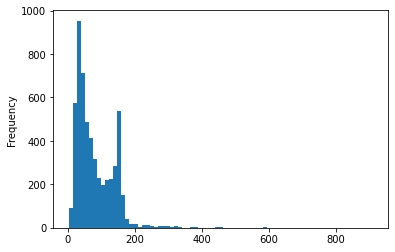

In [8]:
sms['length'].plot(bins=75,kind='hist')

In [9]:
sms.length.describe()

count    5572.000000
mean       80.490309
std        59.944527
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

   Looking at the description of *length*, the smallest message in the data is only 2 characters long while the largest message is 910 characters(with spaces) long! I'm curious to see if the length of a message is a unique feature between spam and ham.

In [10]:
sms[sms['length']==2]['message'].iloc[0]

'Ok'

In [11]:
sms[sms['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

### PREPROCESS:
   Our data needs to be preprocessed into some sort of numerical feature vector in order for the classification algorithms to work. I will be working with the Bag of Words approach(each unique word in a text will be represented by one number.)
   * **In this section:**
  - **Remove punctuations**
  - **Remove common words(ie.stopwords)**
  - **Split each message into individual words and return a list**
  - **Lowercase all words**
  - **Combine in a function to use for later* 

#### 1. Remove Punctuations

In [12]:
sample_sms = 'Sample message!...'
no_punc = [char for char in sample_sms if char not in string.punctuation]
no_punc = ''.join(no_punc)
print(no_punc)

Sample message


#### 2. Remove Stopwords

In [13]:
stopwords.words('english')[0:5]

['i', 'me', 'my', 'myself', 'we']

#### 3. Split words into individual

In [14]:
no_punc.split()

['Sample', 'message']

#### 4. Lowercase Words

In [15]:
lower_sms = [word.lower() for word in no_punc.split() if word.lower() not in stopwords.words('english')]

In [16]:
lower_sms

['sample', 'message']

#### 5. Combine all into a function to apply to dataframe later:

In [17]:
def text_clean(sample_sms):
    no_punc = [char for char in sample_sms if char not in string.punctuation]
    no_punc = ''.join(no_punc) 
    return [word.lower() for word in no_punc.split() if word.lower() not in stopwords.words('english')]
    

In [18]:
sms2 = sms['message'].head().apply(text_clean)

In [19]:
sms2.head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

###### *NLTK has lots of built-in tools and great documentation on a lot of these methods of normalization. These tools--such as Porter Stemmer--are not always great for using with text-messages due to the way many people text using abbreviations or shorthand. It's for this reason that I will be moving onto the next portion of the preprocess:

## Vectorization:
   Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.
   This will take place using the bag-of-words model:
   
   1. **Term frequency**: Count how many times does a word occur in each message
   2. **Inverse document frequency**: Weigh the counts, so that frequent tokens get lower weight
   3. **L2 norm**: Normalize the vectors to unit length, to abstract from the original text length

#### 1. Term Frequency:
  Each vector will have as many dimensions as there are unique words in the sms collection. First, we'll use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.
   
   Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a *Sparse Matrix*

### Bag of Words 

In [20]:
bow_transformer = CountVectorizer(analyzer=text_clean).fit(sms['message'])
print(len(bow_transformer.vocabulary_))

9530


   - Look at one message and get its bag-of-words counts as a vetor:

In [21]:
sms3 = sms['message'][3]
print(sms3)

U dun say so early hor... U c already then say...


   - *Vector representation:*
   This will show how many unique words are in message number 4 (after removing common stopwords). Some words may appear more than once.

In [22]:
bow3 = bow_transformer.transform([sms3])
print(bow3)
print(bow3.shape)

  (0, 1129)	1
  (0, 1910)	1
  (0, 3002)	1
  (0, 3023)	1
  (0, 4219)	1
  (0, 7208)	2
  (0, 8626)	2
(1, 9530)


    - Looks like there are seven unique words with two words appearing twice. 

In [23]:
print(bow_transformer.get_feature_names_out()[7208])
print(bow_transformer.get_feature_names_out()[8626])

say
u


   - Use '.transform' on our bag-of-words (*bow*) transformed object and transform the entire dataframe of messages. Check out how the bow counts for the entire sms collection in a large, sparse matrix:

In [24]:
sms_bow = bow_transformer.transform(sms['message'])

In [25]:
print('Shape of Sparse Matrix:', sms_bow.shape)
print('Amount of non-zero occurences:', sms_bow.nnz)

Shape of Sparse Matrix: (5572, 9530)
Amount of non-zero occurences: 50101


In [26]:
sparsity = (100.0 * sms_bow.nnz/(sms_bow.shape[0] * sms_bow.shape[1]))
print('sparsity:{}'.format(round(sparsity)))

sparsity:0


### TF-IDF
   "*Term Frequency-Inverse Document Frequency*"
   
   The tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the collection. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.
   
   Typically, the tf-idf weight is composed by two terms: 
   1. The first computes the normalized *Term Frequency* (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document. All terms are considered equally important.
         
        a. TF(t) = (Number of times term t appears in a document)/(Total number of terms in the document)
       
       
   2. The second term is the *Inverse Document Frequency* (IDF), computed as the logarithm of the number of the documents in the collection divided by the number of documents where the specific term appears. This measures how important a term is.

        a. IDF(t) = log_e(Total number of documents/Number of documents with term t in it)

In [27]:
tfidf_transformer = TfidfTransformer().fit(sms_bow)
tfidf3 = tfidf_transformer.transform(bow3)
print(tfidf3)

  (0, 8626)	0.31949158769666564
  (0, 7208)	0.5597000940482765
  (0, 4219)	0.46452762500729494
  (0, 3023)	0.33557436526898854
  (0, 3002)	0.30912546538910485
  (0, 1910)	0.2870370340589675
  (0, 1129)	0.27985004702413824


   - Next, check what is the IDF of the words "say" and "u":

In [28]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['say']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])

5.137052417837396
2.932365119299588


In [29]:
sms_tfidf = tfidf_transformer.transform(sms_bow)
print(sms_tfidf.shape)

(5572, 9530)


##### Training the Model: 
   - With 'message' represented as vectors, we can finally train our spam/ham classifier. I am choosing to use the Naive Bayes classifier algorithm.

In [30]:
spam_detect_model = MultinomialNB().fit(sms_tfidf,sms['label'])

In [31]:
print('Predicted:', spam_detect_model.predict(tfidf3)[0])
print('Expected:',sms.label[3])

Predicted: ham
Expected: ham


In [32]:
all_predictions = spam_detect_model.predict(sms_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [33]:
print(classification_report(sms['label'],all_predictions))
print(confusion_matrix(sms['label'],all_predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      4825
        spam       1.00      0.83      0.91       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572

[[4825    0]
 [ 125  622]]


### Train Test Split

   - Our goal is to accurately predict which of the messages are *spam* and which are *ham*. When completed, we should be able to take completely new data and separate each message as *spam* or *ham*.

##### Data Wrangling:

In [34]:
x = sms['message']
y = sms['label']

In [35]:
x_train, x_test, y_train, y_test = train_test_split(
    x,y,test_size = .2, random_state=101)

   - In this case, the value of test_size= is .2, because we are going to use a 80/20 train/test split. This means that we are reserving 20% of the data for testing, and training with the remaining 80%.

In [36]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4457,) (4457,)
(1115,) (1115,)


In [37]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_clean)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

In [38]:
pipeline.fit(x_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_clean at 0x16aa4e4c0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [39]:
predictions = pipeline.predict(x_test)

In [40]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98      1027
        spam       0.65      1.00      0.79        88

    accuracy                           0.96      1115
   macro avg       0.83      0.98      0.88      1115
weighted avg       0.97      0.96      0.96      1115



In [41]:
print("Score:", pipeline.score(x_test, y_test))

Score: 0.957847533632287


   - This means the model is accurate approximately 95% of the time.